In [369]:
from transformers import PatchTSMixerConfig
from tsfm_public.toolkit.dataset import ForecastDFDataset
from tsfm_public.toolkit.time_series_preprocessor import TimeSeriesPreprocessor
from tsfm_public.toolkit.util import select_by_index

In [370]:
import pandas as pd

from tsfm_public.toolkit.dataset import PretrainDFDataset
from tsfm_public.toolkit.time_series_preprocessor import TimeSeriesPreprocessor
from tsfm_public.toolkit.util import select_by_index
from transformers import (
    PatchTSTConfig,
    PatchTSTForPretraining,
    Trainer,
    TrainingArguments,
)

In [371]:
from transformers import set_seed

set_seed(42)


In [372]:
dataset_path = "Data/fishes/fish02/s1/df_timeseries_red_clusters_s1.csv"
timestamp_column = None
id_columns = []
forecast_columns = ["Cluster 1","Cluster 2", "Cluster 3", "Cluster 4","Cluster 5","Cluster 6","Cluster 7","Cluster 8"]



num_workers = 1  # Reduce this if you have low number of CPU cores
batch_size = 14 

In [373]:
data = pd.read_csv(
    dataset_path,
   
)

data['Frame'] = range(0, len(data))
data = data.set_index('Frame')

forecast_columns = list(data.columns)

context_length = 150

train_start_index = 0
train_end_index = 800

eval_start_index = train_end_index - context_length # some overlapp
eval_end_index = 1031

In [374]:
data

,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8
Frame,,,,,,,,
0,-0.465304,-0.039182,-0.145111,-0.820533,-0.043201,0.065635,-0.133898,-1.221447
1,-0.360442,0.565558,-0.029222,-0.730112,0.269952,0.325601,-0.065495,-0.490533
2,-0.204723,0.364503,0.119252,-0.529757,-0.244755,0.430598,0.164129,-0.567888
3,0.062240,0.274655,-0.139845,-0.408598,-0.201634,0.225573,-0.259828,-0.356369
4,-0.331344,0.372020,0.076066,-0.736249,-0.149454,0.482838,-0.297057,-0.240255
...,...,...,...,...,...,...,...,...
1026,-0.776604,-0.709191,0.198898,-0.416232,0.183228,-0.129994,-0.675661,-0.102535
1027,-0.740787,-0.690548,0.037362,-0.570908,0.100399,-0.310062,-0.334169,-0.667639
1028,-1.049494,-0.800837,0.240324,-0.657034,-0.188345,-0.117036,-0.609144,-0.770036


In [32]:
train_data = select_by_index(
    data,
    id_columns=id_columns,
    start_index=train_start_index,
    end_index=train_end_index,
)

eval_data = select_by_index(
    data,
    id_columns=id_columns,
    start_index=eval_start_index,
    end_index=eval_end_index,
)

train_data

NameError: name 'eval_start_index' is not defined

## PatchTST 

In [376]:
tsp = TimeSeriesPreprocessor(
    timestamp_column=None,
    id_columns=id_columns,
    target_columns=forecast_columns,
    scaling=True,
)


time_series_preprocessor = tsp.train(train_data)

train_dataset = PretrainDFDataset(
    train_data,
    id_columns=id_columns,
    target_columns=forecast_columns,
    context_length=context_length,
)

eval_dataset = PretrainDFDataset(
    eval_data,
    timestamp_column=timestamp_column,
    target_columns=forecast_columns,
    context_length=context_length,
)
train_dataset[0]

{'past_values': tensor([[-0.4653, -0.0392, -0.1451,  ...,  0.0656, -0.1339, -1.2214],
         [-0.3604,  0.5656, -0.0292,  ...,  0.3256, -0.0655, -0.4905],
         [-0.2047,  0.3645,  0.1193,  ...,  0.4306,  0.1641, -0.5679],
         ...,
         [ 0.8456,  0.1471,  0.9208,  ...,  0.1069, -0.1956, -1.2693],
         [ 0.8795,  0.4419,  0.8172,  ...,  0.1561,  0.0134, -0.7629],
         [ 0.6542,  0.2013,  0.8720,  ...,  0.0558, -0.0960, -0.7407]])}

In [377]:
patch_length = 10
patch_stride = patch_length

config = PatchTSTConfig(
    num_input_channels=tsp.num_input_channels,
    context_length=context_length,
    patch_length=patch_length,
    patch_stride=patch_stride,
    mask_ratio=0.4,
    d_model=128,
    encoder_attention_heads=4,
    encoder_layers=3,
    encoder_ffn_dim=512,
    dropout=0.2,
    head_dropout=0.2,
    pooling_type=None,
    channel_attention=True,
    scaling="std",
    loss="mse",
    pre_norm=True,
    norm="batchnorm",
    share_embedding=True,
)
pretraining_model = PatchTSTForPretraining(config)


In [378]:
training_args = TrainingArguments(
    output_dir="./checkpoint/pretrain",
    per_device_train_batch_size=10,
    per_device_eval_batch_size=10,
    num_train_epochs=3, #50,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=5,
    logging_strategy="epoch",
    load_best_model_at_end=True,
    # max_steps=10,  # For a quick test
    label_names=["past_values"],
)
pretrainer = Trainer(
    model=pretraining_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)

pretrainer.train()

/home/abasin/anaconda3/envs/proMaster2/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
  0%|          | 0/198 [00:00<?, ?it/s]

 33%|███▎      | 66/198 [00:19<00:42,  3.11it/s]

{'loss': 0.9672, 'grad_norm': 0.8294504880905151, 'learning_rate': 3.3333333333333335e-05, 'epoch': 1.0}


                                                
 33%|███▎      | 66/198 [00:21<00:42,  3.11it/s]

{'eval_loss': 0.9442495107650757, 'eval_runtime': 1.9569, 'eval_samples_per_second': 118.552, 'eval_steps_per_second': 12.264, 'epoch': 1.0}


 67%|██████▋   | 132/198 [00:41<00:13,  4.74it/s]

{'loss': 0.9292, 'grad_norm': 0.8574131727218628, 'learning_rate': 1.6666666666666667e-05, 'epoch': 2.0}


                                                 
 67%|██████▋   | 132/198 [00:43<00:13,  4.74it/s]

{'eval_loss': 0.9077492356300354, 'eval_runtime': 2.1558, 'eval_samples_per_second': 107.615, 'eval_steps_per_second': 11.133, 'epoch': 2.0}


100%|██████████| 198/198 [01:00<00:00,  3.78it/s]

{'loss': 0.9196, 'grad_norm': 1.1564674377441406, 'learning_rate': 0.0, 'epoch': 3.0}


                                                 
100%|██████████| 198/198 [01:03<00:00,  3.13it/s]

{'eval_loss': 0.9000966548919678, 'eval_runtime': 2.1158, 'eval_samples_per_second': 109.651, 'eval_steps_per_second': 11.343, 'epoch': 3.0}
{'train_runtime': 63.1948, 'train_samples_per_second': 30.904, 'train_steps_per_second': 3.133, 'train_loss': 0.9386556606100063, 'epoch': 3.0}


TrainOutput(global_step=198, training_loss=0.9386556606100063, metrics={'train_runtime': 63.1948, 'train_samples_per_second': 30.904, 'train_steps_per_second': 3.133, 'train_loss': 0.9386556606100063, 'epoch': 3.0})

In [379]:
pretrainer.save_model("model/pretrained")

In [380]:
from transformers import PatchTSTModel

# Load the trained model
model = PatchTSTModel.from_pretrained("model/pretrained")
sample = train_dataset[0]
past_values = sample['past_values'].unsqueeze(0)
sample['past_values'][0]

tensor([-0.4653, -0.0392, -0.1451, -0.8205, -0.0432,  0.0656, -0.1339, -1.2214])

### Attention

In [436]:
import torch

# Set the model to evaluation mode
model.eval()

# Disable gradient calculations
with torch.no_grad():
    outputs = model(
        past_values=past_values,
        output_attentions=True,
        output_hidden_states=True,
        return_dict = True
    )


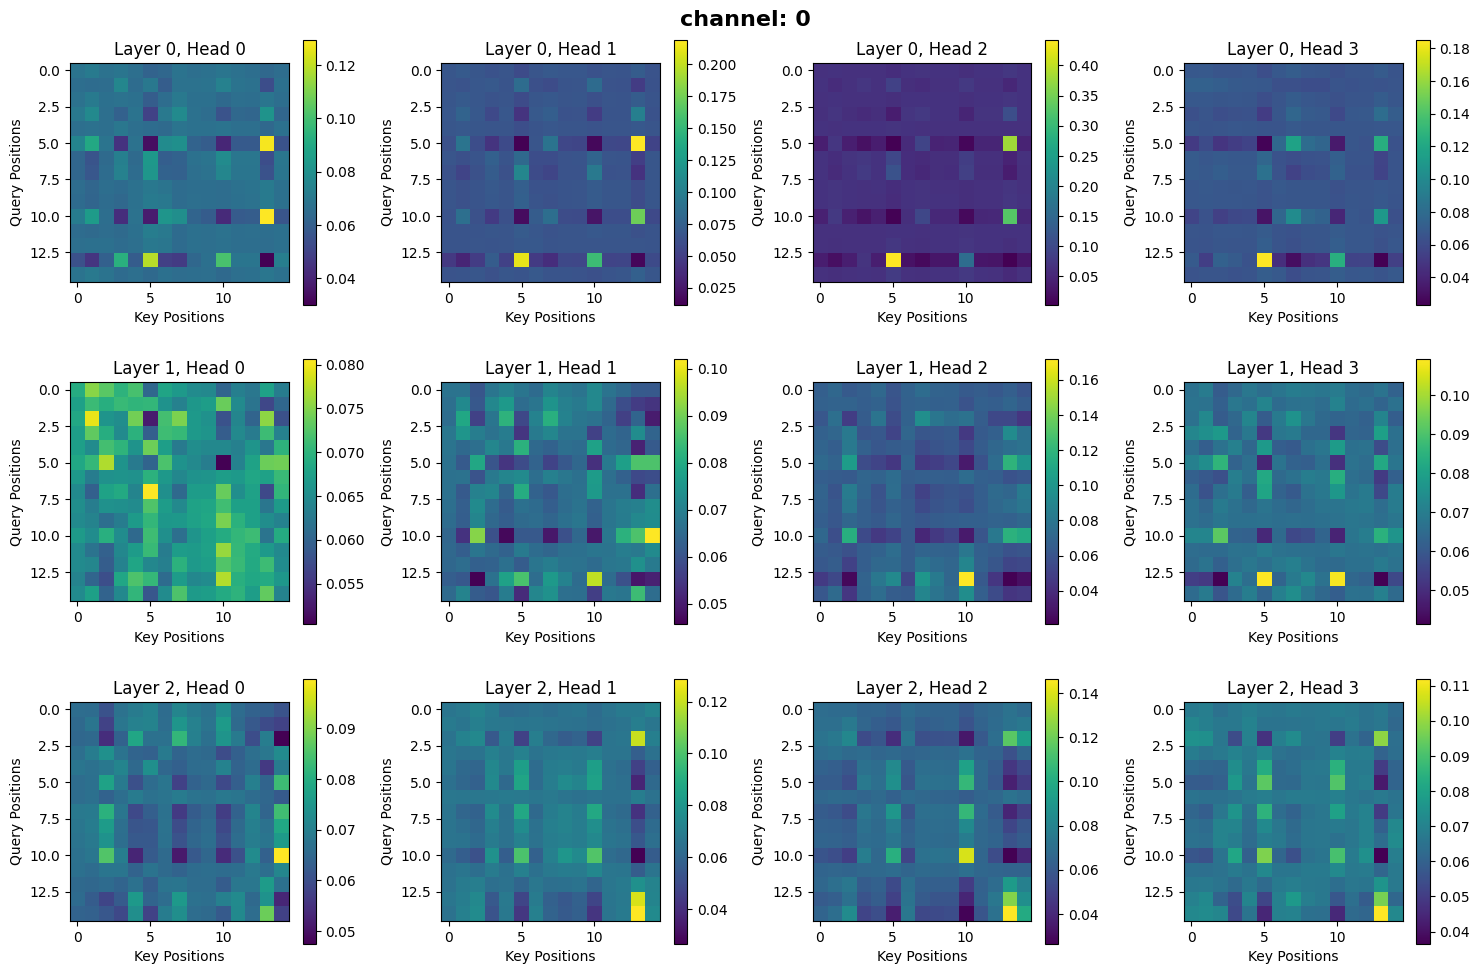

In [382]:
import matplotlib.pyplot as plt
# Extract the attention weights and hidden states
attention_weights = outputs.attentions
hidden_states = outputs.hidden_states

# Select the layers and heads you want to visualize
layers_to_visualize = [0, 1, 2]  # Specify the layer indices
heads_to_visualize = [0,1,2,3]   # Specify the head indices
CHANNEL = 0
# Create subplots for each layer and head
num_layers = len(layers_to_visualize)
num_heads = len(heads_to_visualize)
fig, axes = plt.subplots(num_layers, num_heads, figsize=(15, 10))

for i, layer_idx in enumerate(layers_to_visualize):
    for j, head_idx in enumerate(heads_to_visualize):
        attention_matrix = attention_weights[layer_idx][CHANNEL, head_idx].detach().cpu().numpy()
        ax = axes[i, j] if num_layers > 1 else axes[j]
        im = ax.imshow(attention_matrix, cmap='viridis')
        ax.set_title(f"Layer {layer_idx}, Head {head_idx}")
        ax.set_xlabel("Key Positions")
        ax.set_ylabel("Query Positions")
        fig.colorbar(im, ax=ax)

plt.tight_layout()
plt.suptitle(f"channel: {CHANNEL}",fontsize=16, fontweight='bold')
plt.subplots_adjust(top=0.95)
plt.show()

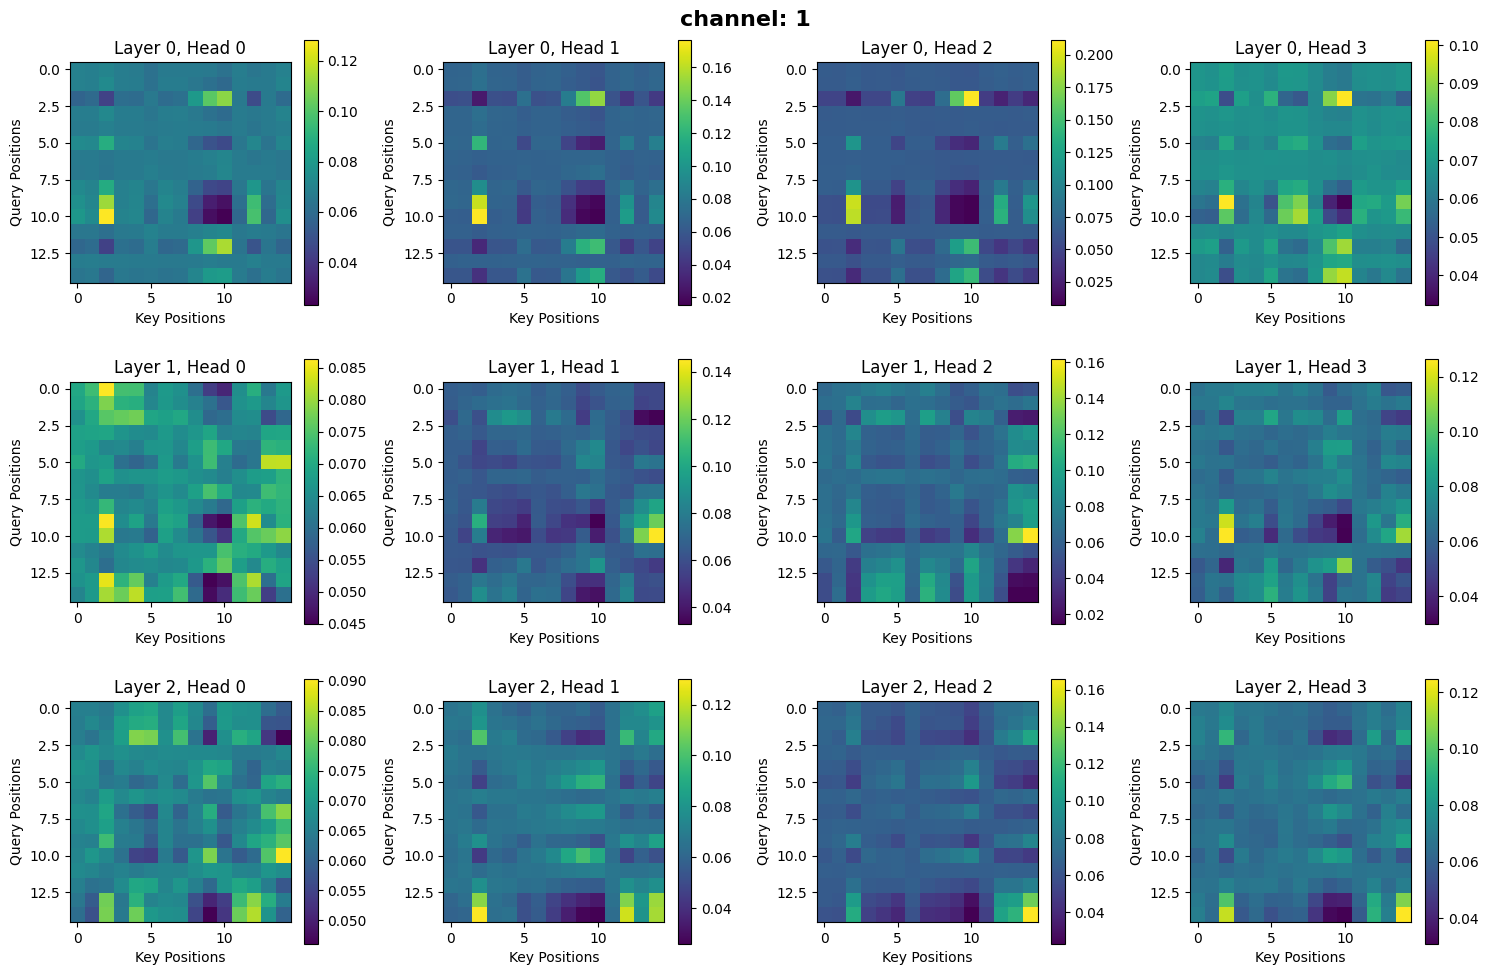

In [383]:
import matplotlib.pyplot as plt
# Extract the attention weights and hidden states
attention_weights = outputs.attentions
hidden_states = outputs.hidden_states

# Select the layers and heads you want to visualize
layers_to_visualize = [0, 1, 2]  # Specify the layer indices
heads_to_visualize = [0,1,2,3]   # Specify the head indices
CHANNEL = 1
# Create subplots for each layer and head
num_layers = len(layers_to_visualize)
num_heads = len(heads_to_visualize)
fig, axes = plt.subplots(num_layers, num_heads, figsize=(15, 10))

for i, layer_idx in enumerate(layers_to_visualize):
    for j, head_idx in enumerate(heads_to_visualize):
        attention_matrix = attention_weights[layer_idx][CHANNEL, head_idx].detach().cpu().numpy()
        ax = axes[i, j] if num_layers > 1 else axes[j]
        im = ax.imshow(attention_matrix, cmap='viridis')
        ax.set_title(f"Layer {layer_idx}, Head {head_idx}")
        ax.set_xlabel("Key Positions")
        ax.set_ylabel("Query Positions")
        fig.colorbar(im, ax=ax)

plt.tight_layout()
plt.suptitle(f"channel: {CHANNEL}",fontsize=16, fontweight='bold')
plt.subplots_adjust(top=0.95)
plt.show()

In [384]:
attention_weights

(tensor([[[[6.8432e-02, 7.0708e-02, 6.7390e-02,  ..., 6.6178e-02,
            6.3662e-02, 6.5622e-02],
           [6.5964e-02, 6.5069e-02, 6.5823e-02,  ..., 6.7340e-02,
            5.3541e-02, 6.6950e-02],
           [6.7737e-02, 7.0760e-02, 6.6872e-02,  ..., 6.6102e-02,
            6.8891e-02, 6.6120e-02],
           ...,
           [6.6306e-02, 6.6698e-02, 6.6753e-02,  ..., 6.6112e-02,
            6.5505e-02, 6.6809e-02],
           [5.4653e-02, 4.5428e-02, 6.0665e-02,  ..., 6.8865e-02,
            3.0130e-02, 7.2823e-02],
           [6.7997e-02, 7.0134e-02, 6.8088e-02,  ..., 6.6734e-02,
            6.8955e-02, 6.7016e-02]],
 
          [[6.7045e-02, 7.0441e-02, 6.7444e-02,  ..., 6.5372e-02,
            7.1961e-02, 6.5299e-02],
           [6.6495e-02, 6.4946e-02, 6.7937e-02,  ..., 6.3842e-02,
            4.8788e-02, 6.4029e-02],
           [6.7061e-02, 7.0715e-02, 6.7829e-02,  ..., 6.6050e-02,
            7.2170e-02, 6.5838e-02],
           ...,
           [6.5994e-02, 6.5866e-02, 6.

In [385]:
# Extract the input values for the specific sample
input_values = past_values[0].detach().cpu().numpy()

# Calculate the time step range for each patch
patch_length = 10  # Replace with your actual patch_length value
patch_stride = 10  # Replace with your actual patch_stride value
num_patches = input_values.shape[0] // patch_length
time_step_ranges = [(i * patch_stride, (i + 1) * patch_stride - 1) for i in range(num_patches)]

# Identify the channel for each patch (assuming single channel per patch)
channels = ["Channel {}".format(i // patch_length) for i in range(input_values.shape[0])]
channels

['Channel 0',
 'Channel 0',
 'Channel 0',
 'Channel 0',
 'Channel 0',
 'Channel 0',
 'Channel 0',
 'Channel 0',
 'Channel 0',
 'Channel 0',
 'Channel 1',
 'Channel 1',
 'Channel 1',
 'Channel 1',
 'Channel 1',
 'Channel 1',
 'Channel 1',
 'Channel 1',
 'Channel 1',
 'Channel 1',
 'Channel 2',
 'Channel 2',
 'Channel 2',
 'Channel 2',
 'Channel 2',
 'Channel 2',
 'Channel 2',
 'Channel 2',
 'Channel 2',
 'Channel 2',
 'Channel 3',
 'Channel 3',
 'Channel 3',
 'Channel 3',
 'Channel 3',
 'Channel 3',
 'Channel 3',
 'Channel 3',
 'Channel 3',
 'Channel 3',
 'Channel 4',
 'Channel 4',
 'Channel 4',
 'Channel 4',
 'Channel 4',
 'Channel 4',
 'Channel 4',
 'Channel 4',
 'Channel 4',
 'Channel 4',
 'Channel 5',
 'Channel 5',
 'Channel 5',
 'Channel 5',
 'Channel 5',
 'Channel 5',
 'Channel 5',
 'Channel 5',
 'Channel 5',
 'Channel 5',
 'Channel 6',
 'Channel 6',
 'Channel 6',
 'Channel 6',
 'Channel 6',
 'Channel 6',
 'Channel 6',
 'Channel 6',
 'Channel 6',
 'Channel 6',
 'Channel 7',
 'Chan

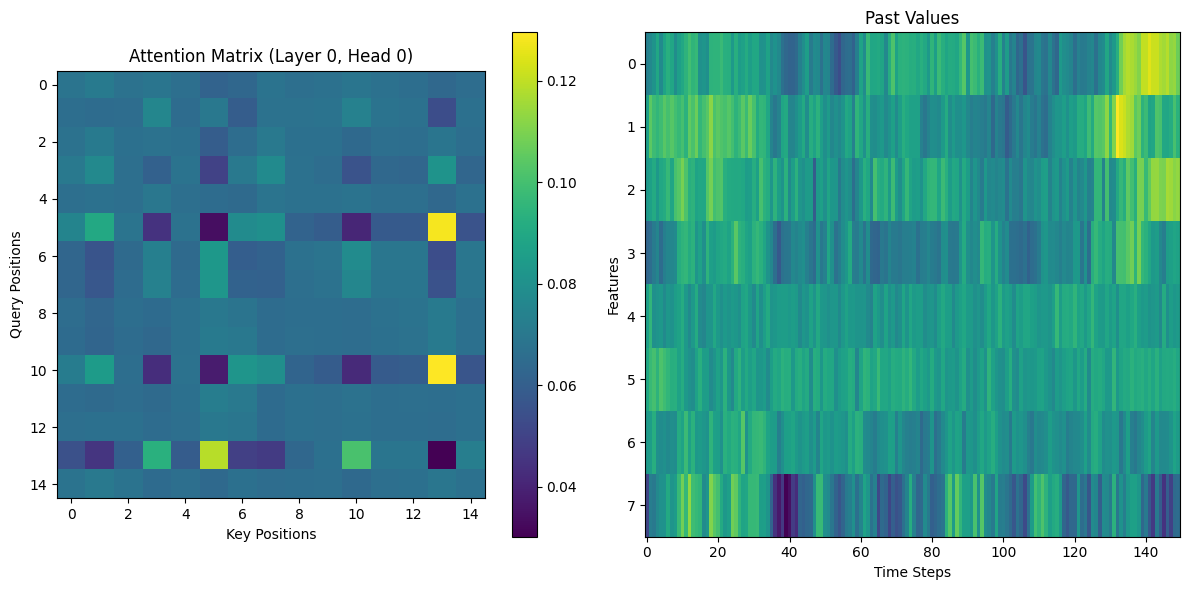

In [386]:
import matplotlib.pyplot as plt

# ... (previous code remains the same)

# Select a specific head and layer to visualize
layer_idx = 0
head_idx = 0

# Extract the attention matrix for the selected head and layer
attention_matrix = attention_weights[layer_idx][0, head_idx].detach().cpu().numpy()

# Create a figure with two subplots: one for the attention matrix and one for the past_values
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the attention matrix
im = ax1.imshow(attention_matrix, cmap='viridis')
ax1.set_title(f"Attention Matrix (Layer {layer_idx}, Head {head_idx})")
ax1.set_xlabel("Key Positions")
ax1.set_ylabel("Query Positions")
fig.colorbar(im, ax=ax1)

# Plot the past_values tensor
past_values_plot = past_values[0].detach().cpu().numpy()
ax2.imshow(past_values_plot.T, aspect='auto', cmap='viridis')
ax2.set_title("Past Values")
ax2.set_xlabel("Time Steps")
ax2.set_ylabel("Features")

plt.tight_layout()
plt.show()

In [387]:
attention_matrix.shape

(15, 15)

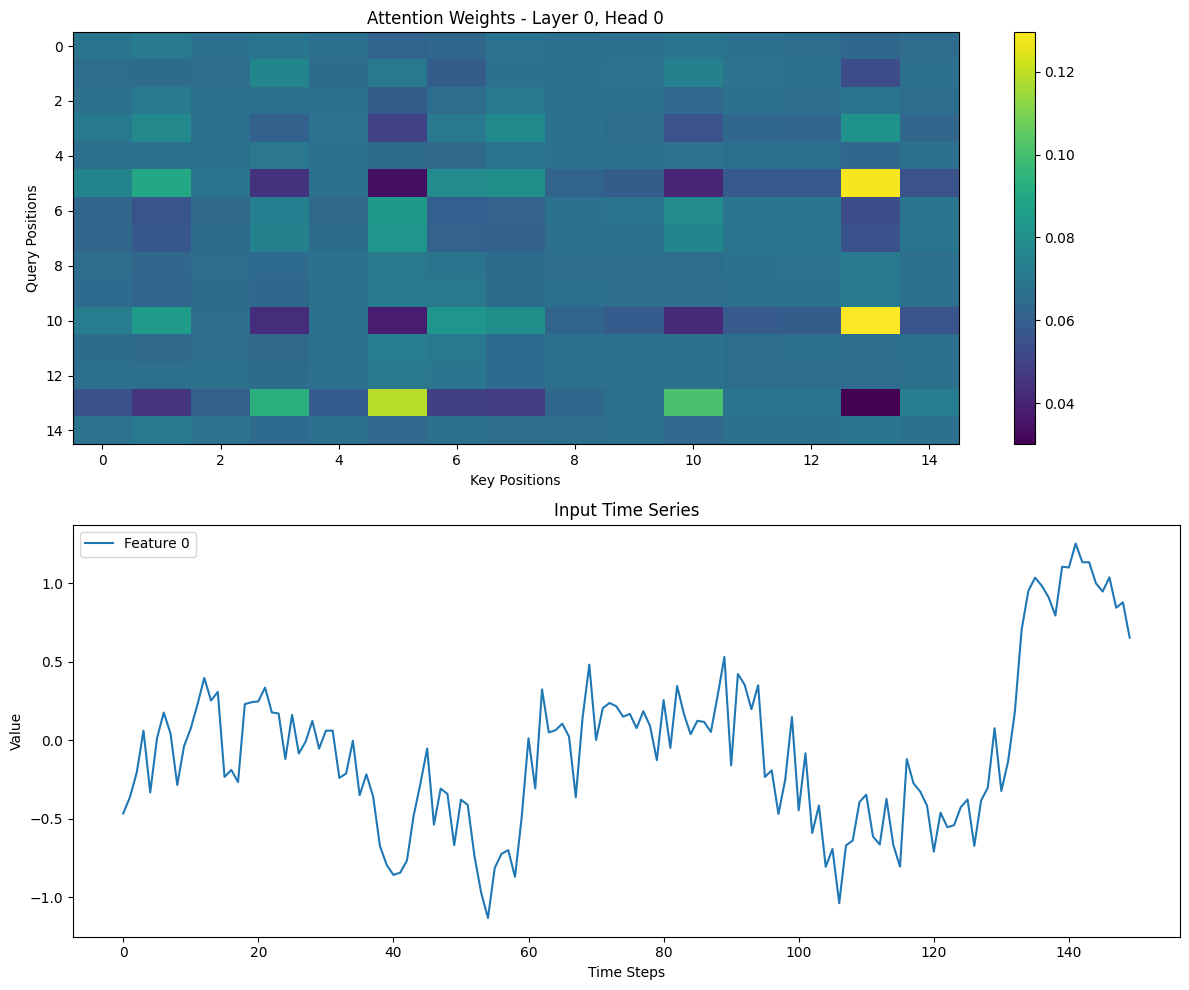

In [388]:
import torch
import matplotlib.pyplot as plt
import numpy as np


# Extract the attention weights and hidden states
attention_weights = outputs.attentions
hidden_states = outputs.hidden_states

# Select the layer and head you want to visualize
layer_idx = 0
head_idx = 0

# Get the attention weights for the selected layer and head
attention_matrix = attention_weights[layer_idx][0, head_idx].detach().cpu().numpy()

# Get the number of time steps and features in the input data
num_timesteps, num_features = past_values.shape[1], past_values.shape[2]

# Create a figure with two subplots: one for the attention heatmap and one for the time series
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot the attention heatmap
im = ax1.imshow(attention_matrix, cmap='viridis', aspect='auto')
ax1.set_title(f"Attention Weights - Layer {layer_idx}, Head {head_idx}")
ax1.set_xlabel("Key Positions")
ax1.set_ylabel("Query Positions")
fig.colorbar(im, ax=ax1)

# Plot the time series
for i in range(num_features):
    ax2.plot(past_values[0, :, i].detach().cpu().numpy(), label=f"Feature {i}")
    break
ax2.set_title("Input Time Series")
ax2.set_xlabel("Time Steps")
ax2.set_ylabel("Value")
ax2.legend()

plt.tight_layout()
plt.show()


In [427]:
sample_attn_weights = outputs.attentions[-1]
sample_attn_weights[0].shape
outputs.attentions[-1][0]

tensor([[[0.0661, 0.0660, 0.0607, 0.0673, 0.0691, 0.0706, 0.0660, 0.0712,
          0.0688, 0.0672, 0.0728, 0.0660, 0.0640, 0.0634, 0.0609],
         [0.0653, 0.0678, 0.0578, 0.0679, 0.0705, 0.0709, 0.0662, 0.0747,
          0.0705, 0.0675, 0.0760, 0.0655, 0.0620, 0.0594, 0.0578],
         [0.0648, 0.0654, 0.0543, 0.0639, 0.0783, 0.0669, 0.0670, 0.0820,
          0.0702, 0.0668, 0.0745, 0.0690, 0.0598, 0.0695, 0.0475],
         [0.0667, 0.0694, 0.0738, 0.0674, 0.0643, 0.0637, 0.0688, 0.0643,
          0.0659, 0.0653, 0.0596, 0.0635, 0.0665, 0.0682, 0.0726],
         [0.0679, 0.0670, 0.0685, 0.0711, 0.0654, 0.0736, 0.0648, 0.0635,
          0.0660, 0.0661, 0.0707, 0.0641, 0.0659, 0.0562, 0.0692],
         [0.0661, 0.0667, 0.0775, 0.0689, 0.0603, 0.0659, 0.0677, 0.0576,
          0.0640, 0.0653, 0.0590, 0.0633, 0.0701, 0.0643, 0.0833],
         [0.0662, 0.0667, 0.0639, 0.0663, 0.0692, 0.0670, 0.0675, 0.0693,
          0.0674, 0.0671, 0.0685, 0.0678, 0.0659, 0.0650, 0.0624],
         [0.0

In [408]:

self_attention_weights = outputs.attentions

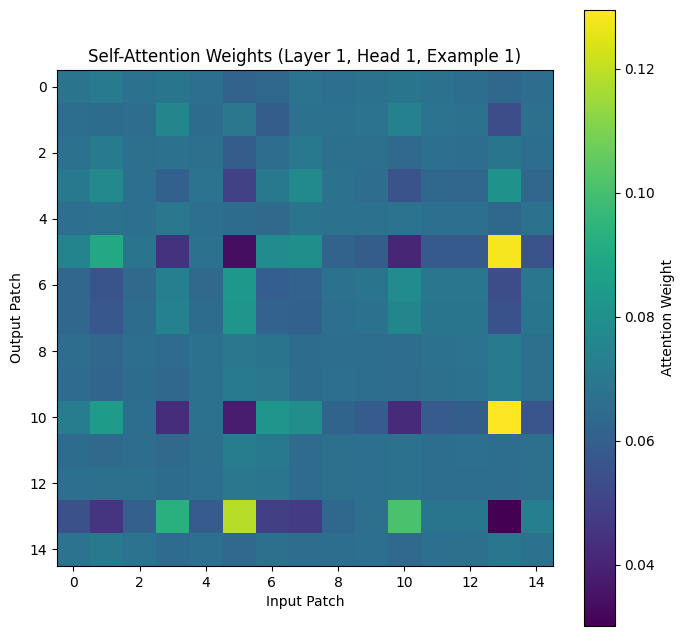

In [409]:
import matplotlib.pyplot as plt

layer_idx = 0
head_idx = 0
example_idx = 0

attention_weights = self_attention_weights[layer_idx][example_idx, head_idx]
plt.figure(figsize=(8, 8))
plt.imshow(attention_weights.detach().numpy(), cmap='viridis')
plt.colorbar(label='Attention Weight')
plt.xlabel('Input Patch')
plt.ylabel('Output Patch')
plt.title(f'Self-Attention Weights (Layer {layer_idx+1}, Head {head_idx+1}, Example {example_idx+1})')
plt.show()

In [437]:
return_dict= outputs.return_dict

AttributeError: 'PatchTSTModelOutput' object has no attribute 'return_dict'

In [444]:
hidden_states[0].shape

torch.Size([1, 8, 15, 128])

In [439]:
channel_attention_weights = []
for layer in model.encoder.layers:
    attention_weights = layer.channel_attention.qkv.weight
    channel_attention_weights.append(attention_weights)

AttributeError: 'bool' object has no attribute 'qkv'

In [433]:
import matplotlib.pyplot as plt
layer_idx = 0
example_idx = 0

attention_weights = channel_attention_weights[layer_idx][example_idx]
plt.figure(figsize=(8, 8))
plt.imshow(attention_weights.detach().numpy(), cmap='viridis')
plt.colorbar(label='Attention Weight')
plt.xlabel('Input Channel')
plt.ylabel('Output Channel')
plt.title(f'Channel Attention Weights (Layer {layer_idx+1}, Example {example_idx+1})')

# Add channel labels
plt.xticks(range(8), forecast_columns, rotation=45, ha='right')
plt.yticks(range(8), forecast_columns)

plt.tight_layout()
plt.show()

AttributeError: 'bool' object has no attribute 'attention_weights'

## PatchTsMiXER

In [39]:
import os
import random

from transformers import (
    EarlyStoppingCallback,
    PatchTSMixerConfig,
    PatchTSMixerForPrediction,
    PatchTSMixerPreTrainedModel,
   
    Trainer,
    TrainingArguments,
)
import numpy as np
import pandas as pd
import torch
from tsfm_public.toolkit.dataset import PretrainDFDataset

from tsfm_public.toolkit.dataset import ForecastDFDataset
from tsfm_public.toolkit.time_series_preprocessor import TimeSeriesPreprocessor
from tsfm_public.toolkit.util import select_by_index


In [46]:
# Download ECL data from https://github.com/zhouhaoyi/Informer2020


dataset_path = "Data/fishes/fish02/s1/df_timeseries_red_clusters_s1.csv"
timestamp_column = None
id_columns = []
forecast_columns = ["Cluster 1","Cluster 2", "Cluster 3", "Cluster 4","Cluster 5","Cluster 6","Cluster 7","Cluster 8"]



context_length = 150
forecast_horizon = 96
patch_length = 10
num_workers = 1  # Reduce this if you have low number of CPU cores
batch_size = 10

data = pd.read_csv(
    dataset_path,
)
forecast_columns = list(data.columns[0:])
PRETRAIN_AGAIN = True

"""# get split
num_train = int(len(data) * 0.7)
num_test = int(len(data) * 0.2)
num_valid = len(data) - num_train - num_test
border1s = [
    0,
    num_train - context_length,
    len(data) - num_test - context_length,
]
border2s = [num_train, num_train + num_valid, len(data)]

train_start_index = border1s[0]  # None indicates beginning of dataset
train_end_index = border2s[0]

# we shift the start of the evaluation period back by context length so that
# the first evaluation timestamp is immediately following the training data
valid_start_index = border1s[1]
valid_end_index = border2s[1]

test_start_index = border1s[2]
test_end_index = border2s[2]"""

'# get split\nnum_train = int(len(data) * 0.7)\nnum_test = int(len(data) * 0.2)\nnum_valid = len(data) - num_train - num_test\nborder1s = [\n    0,\n    num_train - context_length,\n    len(data) - num_test - context_length,\n]\nborder2s = [num_train, num_train + num_valid, len(data)]\n\ntrain_start_index = border1s[0]  # None indicates beginning of dataset\ntrain_end_index = border2s[0]\n\n# we shift the start of the evaluation period back by context length so that\n# the first evaluation timestamp is immediately following the training data\nvalid_start_index = border1s[1]\nvalid_end_index = border2s[1]\n\ntest_start_index = border1s[2]\ntest_end_index = border2s[2]'

In [41]:

data = pd.read_csv(
    dataset_path,
   
)

data['Frame'] = range(0, len(data))
data = data.set_index('Frame')

forecast_columns = list(data.columns)

context_length = 150

train_start_index = 0
train_end_index = 800

eval_start_index = train_end_index - context_length # some overlapp
eval_end_index = 1031


train_data = select_by_index(
    data,
    id_columns=id_columns,
    start_index=train_start_index,
    end_index=train_end_index,
)

eval_data = select_by_index(
    data,
    id_columns=id_columns,
    start_index=eval_start_index,
    end_index=eval_end_index,
)

train_data

,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8
Frame,,,,,,,,
0,-0.465304,-0.039182,-0.145111,-0.820533,-0.043201,0.065635,-0.133898,-1.221447
1,-0.360442,0.565558,-0.029222,-0.730112,0.269952,0.325601,-0.065495,-0.490533
2,-0.204723,0.364503,0.119252,-0.529757,-0.244755,0.430598,0.164129,-0.567888
3,0.062240,0.274655,-0.139845,-0.408598,-0.201634,0.225573,-0.259828,-0.356369
4,-0.331344,0.372020,0.076066,-0.736249,-0.149454,0.482838,-0.297057,-0.240255
...,...,...,...,...,...,...,...,...
795,-0.530842,-0.631542,0.503371,-0.582628,-0.425051,-0.140273,-0.309642,0.187763
796,-1.056270,-0.071068,0.569493,-0.411835,-0.330032,0.261568,-0.205286,-0.309031
797,-1.119810,-0.464791,0.158023,-0.249315,0.009424,0.200395,-0.092526,-1.072714


In [42]:

"""valid_start_index = border1s[1]
valid_end_index = border2s[1]

test_start_index = border1s[2]
test_end_index = border2s[2]

train_data = select_by_index(
    data,
    id_columns=id_columns,
    start_index=train_start_index,
    end_index=train_end_index,
)
valid_data = select_by_index(
    data,
    id_columns=id_columns,
    start_index=valid_start_index,
    end_index=valid_end_index,
)
test_data = select_by_index(
    data,
    id_columns=id_columns,
    start_index=test_start_index,
    end_index=test_end_index,
)
"""



'valid_start_index = border1s[1]\nvalid_end_index = border2s[1]\n\ntest_start_index = border1s[2]\ntest_end_index = border2s[2]\n\ntrain_data = select_by_index(\n    data,\n    id_columns=id_columns,\n    start_index=train_start_index,\n    end_index=train_end_index,\n)\nvalid_data = select_by_index(\n    data,\n    id_columns=id_columns,\n    start_index=valid_start_index,\n    end_index=valid_end_index,\n)\ntest_data = select_by_index(\n    data,\n    id_columns=id_columns,\n    start_index=test_start_index,\n    end_index=test_end_index,\n)\n'

In [59]:
"""train_dataset = ForecastDFDataset(
    train_data,
    id_columns=id_columns,
    target_columns=forecast_columns,
    context_length=context_length,
    prediction_length=forecast_horizon,
)
valid_dataset = ForecastDFDataset(
    valid_data,
    id_columns=id_columns,
    target_columns=forecast_columns,
    context_length=context_length,
    prediction_length=forecast_horizon,
)
test_dataset = ForecastDFDataset(
    test_data,
    id_columns=id_columns,
    target_columns=forecast_columns,
    context_length=context_length,
    prediction_length=forecast_horizon,
)"""

tsp = TimeSeriesPreprocessor(
    timestamp_column=None,
    id_columns=id_columns,
    target_columns=forecast_columns,
    scaling=True,
)


time_series_preprocessor = tsp.train(train_data)

train_dataset = PretrainDFDataset(
    train_data,
    id_columns=id_columns,
    target_columns=forecast_columns,
    context_length=context_length,
)

eval_dataset = PretrainDFDataset(
    eval_data,
    id_columns=id_columns,
    timestamp_column=timestamp_column,
    target_columns=forecast_columns,
    context_length=context_length,
)
train_dataset[0]

{'past_values': tensor([[-0.4653, -0.0392, -0.1451,  ...,  0.0656, -0.1339, -1.2214],
         [-0.3604,  0.5656, -0.0292,  ...,  0.3256, -0.0655, -0.4905],
         [-0.2047,  0.3645,  0.1193,  ...,  0.4306,  0.1641, -0.5679],
         ...,
         [ 0.8456,  0.1471,  0.9208,  ...,  0.1069, -0.1956, -1.2693],
         [ 0.8795,  0.4419,  0.8172,  ...,  0.1561,  0.0134, -0.7629],
         [ 0.6542,  0.2013,  0.8720,  ...,  0.0558, -0.0960, -0.7407]])}

In [60]:
patch_length = 10
patch_stride = patch_length

if PRETRAIN_AGAIN:
    config = PatchTSMixerConfig(
        context_length=context_length,
        prediction_length=forecast_horizon,
        patch_length=patch_length,
        num_input_channels=len(forecast_columns),
        patch_stride=patch_length,
        d_model=16,
        num_layers=8,
        expansion_factor=2,
        dropout=0.2,
        head_dropout=0.2,
        mode="mix_channel",
        scaling="std",
    )
pretraining_model = PatchTSMixerPreTrainedModel(config)

In [61]:
if PRETRAIN_AGAIN:
    training_args = TrainingArguments(
        output_dir="./checkpoint/patchtsmixer_4/electricity/pretrain/output/",
        overwrite_output_dir=True,
        learning_rate=0.001,
        num_train_epochs=1,  # For a quick test of this notebook, set it to 1
        do_eval=True,
        evaluation_strategy="epoch",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        dataloader_num_workers=num_workers,
        report_to="tensorboard",
        save_strategy="epoch",
        logging_strategy="epoch",
        save_total_limit=3,
        logging_dir="./checkpoint/patchtsmixer_4/electricity/pretrain/logs/",  # Make sure to specify a logging directory
        load_best_model_at_end=True,  # Load the best model when training ends
        metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
        greater_is_better=False,  # For loss
        label_names=["past_values"],
    )

    # Create the early stopping callback
    early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience=10,  # Number of epochs with no improvement after which to stop
        early_stopping_threshold=0.0001,  # Minimum improvement required to consider as improvement
    )
    
    
training_args = TrainingArguments(
    output_dir="./checkpoint/pretrain",
    per_device_train_batch_size=10,
    per_device_eval_batch_size=10,
    num_train_epochs=3, #50,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=5,
    logging_strategy="epoch",
    load_best_model_at_end=True,
    # max_steps=10,  # For a quick test
    label_names=["past_values"],
)
    # define trainer
trainer = Trainer(
        model=pretraining_model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        callbacks=[early_stopping_callback],
    )

    # pretrain
trainer.train()

/home/abasin/anaconda3/envs/proMaster2/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
  0%|          | 0/198 [00:00<?, ?it/s]

TypeError: _forward_unimplemented() got an unexpected keyword argument 'past_values'

In [26]:
save_dir = "model/mixer"
os.makedirs(save_dir, exist_ok=True)
trainer.save_model(save_dir)

In [62]:
from transformers import PatchTSMixerModel

# Load the trained model
model = PatchTSMixerModel.from_pretrained("model/mixer")
sample = train_dataset[0]
past_values = sample['past_values'].unsqueeze(0)
sample['past_values'][0]

tensor([-0.4653, -0.0392, -0.1451, -0.8205, -0.0432,  0.0656, -0.1339, -1.2214])

In [68]:
# Set the model to evaluation mode
model.eval()

# Disable gradient calculations
with torch.no_grad():
    outputs = model(
        past_values=past_values,
        output_hidden_states=True
        
        
    )
    
    


In [71]:
len(outputs.hidden_states[0].shape)


4